In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms.functional import rotate, hflip
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import glob

In [2]:
# name = "emnistbyclass"
# name = "emnistbalanced"
name = "emnistbalanced_mathsymbols_custom"
# name = "mnist"
# name = "mathsymbols"
# name = "mnist_mathsymbols"
# name = "emnistbyclass_mathsymbols"

In [3]:
# EMNIST dataset
# split = "byclass"
# split = 'bymerge'
split = "balanced"
# split = 'letters'
# split = 'digits'
# split = "mnist"
emnist_train_data = datasets.EMNIST(
    root="data",
    split=split,
    train=True,
    download=True,
    transform=Compose([lambda img: rotate(img, -90), lambda img: hflip(img), ToTensor()]),
    target_transform=Lambda(lambda y: torch.tensor(y)),
)
emnist_test_data = datasets.EMNIST(
    root="data",
    split=split,
    train=False,
    download=True,
    transform=Compose([lambda img: rotate(img, -90), lambda img: hflip(img), ToTensor()]),
    target_transform=Lambda(lambda y: torch.tensor(y)),
)

In [4]:
# math_symbols = ["-", "(", ")", ",", "[", "]", "+", "=", "forward_slash", "gt", "lt", "times"]
math_symbols = ["gt"]

custom_symbols = ["colon"]

class_names = []

if "mnist" in name:
    class_names += [str(num) for num in range(10)]

if "emnist" in name:
    class_names += [chr(capital) for capital in range(ord("A"), ord("Z") + 1)]
    class_names += [chr(lower) for lower in range(ord("a"), ord("z") + 1)]

if "balanced" in name:
    class_names = [
        x
        for x in class_names
        if x not in {"c", "i", "j", "k", "l", "m", "o", "p", "s", "u", "v", "w", "x", "y", "z"}
    ]

if "math" in name:
    class_names += math_symbols

if "custom" in name:
    class_names += custom_symbols

print(len(class_names))
print(class_names)

49
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't', 'gt', 'colon']


In [5]:
# Math Symbols dataset
class MathSymbolsDataset(Dataset):
    def __init__(self, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]

        im = cv2.imread(img_path)

        # Grayscale
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # Flip black and white
        im = cv2.bitwise_not(im)

        # Make lines thicker
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
        im = cv2.dilate(im, kernel, iterations=1)

        # Gaussian blur
        im = cv2.GaussianBlur(im, ksize=(3, 3), sigmaX=1, sigmaY=1)

        # Resize to 24x24
        im = cv2.resize(im, (24, 24), interpolation=cv2.INTER_CUBIC)

        # Add 2 pixel border for total size of 28x28
        border = 2
        im = cv2.copyMakeBorder(
            im, border, border, border, border, cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )

        # Normalize
        im = im / 255

        # Convert to tensor
        image = torch.from_numpy(im.astype("float32")).unsqueeze(0)

        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label).type(torch.LongTensor)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


math_symbols_root = "data/math_symbols"

# EMNIST balanced has 2400 train samples per class
target_samples = 2400

data = []
for i, symbol in enumerate(math_symbols):
    root = f"{math_symbols_root}/{symbol}"
    files = os.listdir(root)
    for file in files:
        path = f"{root}/{file}"
        label = i
        data.append([path, label])
data = np.array(data)

img_labels = pd.DataFrame(columns=["path", "label"])
img_labels["path"] = data[:, 0]
img_labels["label"] = data[:, 1].astype(int)

offset = 0
if "mnist" in name:
    offset += 10
if "emnist" in name:
    offset += 52
if "balanced" in name:
    offset -= 15
img_labels["label"] = img_labels["label"] + offset
display(img_labels)
display(img_labels.info())

math_symbols_dataset = MathSymbolsDataset(img_labels)
print("Math symbols dataset:", len(math_symbols_dataset), math_symbols_dataset[0][0].size())

math_symbols_train_size = int(0.9 * len(math_symbols_dataset))
math_symbols_test_size = len(math_symbols_dataset) - math_symbols_train_size
math_symbols_train_data, math_symbols_test_data = torch.utils.data.random_split(
    math_symbols_dataset, [math_symbols_train_size, math_symbols_test_size]
)

,path,label
0,data/math_symbols/gt/exp1.jpg,47
1,data/math_symbols/gt/exp1009.jpg,47
2,data/math_symbols/gt/exp1037.jpg,47
3,data/math_symbols/gt/exp104081.jpg,47
4,data/math_symbols/gt/exp104819.jpg,47
...,...,...
253,data/math_symbols/gt/gt_98800.jpg,47
254,data/math_symbols/gt/gt_99628.jpg,47
255,data/math_symbols/gt/gt_99668.jpg,47
256,data/math_symbols/gt/gt_99835.jpg,47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    258 non-null    object
 1   label   258 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 3.1+ KB


None

Math symbols dataset: 258 torch.Size([1, 28, 28])


In [6]:
# Custom Symbols dataset
class CustomSymbolsDataset(Dataset):
    def __init__(self, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]

        im = cv2.imread(img_path)

        # Grayscale
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        # Normalize
        im = im / 255

        # Convert to tensor
        image = torch.from_numpy(im.astype("float32")).unsqueeze(0)

        label = self.img_labels.iloc[idx, 1]
        label = torch.tensor(label).type(torch.LongTensor)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


custom_symbols_root = "data/custom_symbols"

# EMNIST balanced has 2400 train samples per class
target_samples = 2400

data = []
for file in glob.glob(f"{custom_symbols_root}/**/*.jpg", recursive=True):
    path = file.replace("\\", "/")
    label = i
    data.append([path, label])
data = np.array(data)

img_labels = pd.DataFrame(columns=["path", "label"])
img_labels["path"] = data[:, 0]
img_labels["label"] = data[:, 1].astype(int)

offset = 0
if "mnist" in name:
    offset += 10
if "emnist" in name:
    offset += 52
if "balanced" in name:
    offset -= 15
if "math" in name:
    offset += len(math_symbols)
img_labels["label"] = img_labels["label"] + offset
display(img_labels)
display(img_labels.info())

custom_symbols_dataset = CustomSymbolsDataset(img_labels)
print("Custom symbols dataset:", len(custom_symbols_dataset), custom_symbols_dataset[0][0].size())

custom_symbols_train_size = int(0.9 * len(custom_symbols_dataset))
custom_symbols_test_size = len(custom_symbols_dataset) - custom_symbols_train_size
custom_symbols_train_data, custom_symbols_test_data = torch.utils.data.random_split(
    custom_symbols_dataset, [custom_symbols_train_size, custom_symbols_test_size]
)

,path,label
0,data/custom_symbols/colon/colon_0.jpg,48
1,data/custom_symbols/colon/colon_1.jpg,48
2,data/custom_symbols/colon/colon_2.jpg,48
3,data/custom_symbols/colon/colon_3.jpg,48
4,data/custom_symbols/colon/colon_4.jpg,48
...,...,...
105,data/custom_symbols/colon/aug/colon_9_aug5.jpg,48
106,data/custom_symbols/colon/aug/colon_9_aug6.jpg,48
107,data/custom_symbols/colon/aug/colon_9_aug7.jpg,48
108,data/custom_symbols/colon/aug/colon_9_aug8.jpg,48


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    110 non-null    object
 1   label   110 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 1.4+ KB


None

Custom symbols dataset: 110 torch.Size([1, 28, 28])


In [7]:
train_data = []
test_data = []

if "mnist" in name:
    train_data.append(emnist_train_data)
    test_data.append(emnist_test_data)

if "math" in name:
    train_data.append(math_symbols_train_data)
    test_data.append(math_symbols_test_data)

if "custom" in name:
    train_data.append(custom_symbols_train_data)
    test_data.append(custom_symbols_test_data)

if len(train_data) == 1:
    train_data = train_data[0]
    test_data = test_data[0]
else:
    train_data = ConcatDataset(train_data)
    test_data = ConcatDataset(test_data)

Label: U


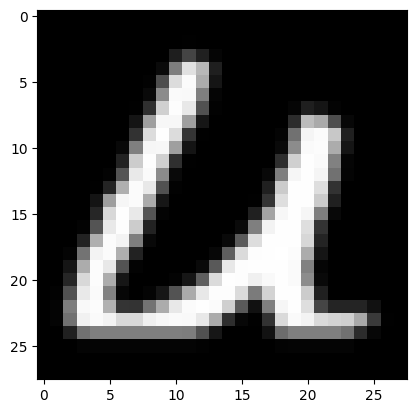

In [8]:
idx = np.random.randint(0, len(train_data))
sample_img, sample_label = train_data[idx]
plt.imshow(sample_img.reshape(28, 28), cmap="gray")
print("Label:", class_names[sample_label])

In [9]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# for X, y in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break

n_classes = len(class_names)
print("n_classes:", n_classes)

n_classes: 49


In [10]:
device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout(p=0.4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=64 * 20 * 20, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=128),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=128, out_features=n_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            preds += pred.argmax(1).tolist()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.891289  [   64/113131]
loss: 1.145168  [ 6464/113131]
loss: 0.817577  [12864/113131]
loss: 0.702859  [19264/113131]
loss: 0.624923  [25664/113131]
loss: 0.556998  [32064/113131]
loss: 0.499433  [38464/113131]
loss: 0.544676  [44864/113131]
loss: 0.607026  [51264/113131]
loss: 0.398142  [57664/113131]
loss: 0.673238  [64064/113131]
loss: 0.490691  [70464/113131]
loss: 0.489539  [76864/113131]
loss: 0.487327  [83264/113131]
loss: 0.312796  [89664/113131]
loss: 0.464911  [96064/113131]
loss: 0.338532  [102464/113131]
loss: 0.358299  [108864/113131]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.385599 

Epoch 2
-------------------------------
loss: 0.524999  [   64/113131]
loss: 0.253564  [ 6464/113131]
loss: 0.413700  [12864/113131]
loss: 0.550712  [19264/113131]
loss: 0.246696  [25664/113131]
loss: 0.396192  [32064/113131]
loss: 0.316482  [38464/113131]
loss: 0.281391  [44864/113131]
loss: 0.385326  [51264/113131]
loss: 0.201758  [57664/113131

In [15]:
torch.save(model.state_dict(), f"model_{name}.pth")

In [16]:
model = CNN()
model.load_state_dict(torch.load(f"model_{name}.pth"))
model = model.to(device)

Predicted: "t", Actual: "t"


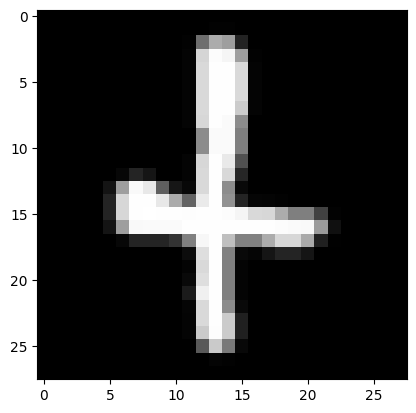

In [17]:
model.eval()
idx = np.random.randint(0, len(test_data))
x, y = test_data[idx]
with torch.no_grad():
    x = x.unsqueeze(0)
    pred = model(x.to(device))
    predicted, actual = class_names[pred[0].argmax(0)], class_names[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.imshow(x.reshape(28, 28), cmap="gray")

In [18]:
# preds = test(test_dataloader, model, loss_fn)

In [19]:
# target_class = "l"
# targets = []
# for img, label in test_data:
#     label = label.item()
#     class_name = class_names[label]
#     if class_name == target_class:
#         targets.append(img)

In [20]:
# idx = np.random.randint(0, len(targets))
# plt.imshow(targets[idx].reshape(28, 28), cmap="gray")

In [21]:
counts = dict()
for img, label in train_data:
    class_name = class_names[label.item()]
    counts[class_name] = counts.get(class_name, 0) + 1
print(counts)

{'r': 2400, 'a': 2400, 'n': 2400, 'F': 2400, '4': 2400, 'h': 2400, 'Q': 2400, 'W': 2400, 'K': 2400, '1': 2400, 't': 2400, 'D': 2400, 'O': 2400, 'C': 2400, '5': 2400, 'H': 2400, '3': 2400, 'f': 2400, 'E': 2400, 'q': 2400, 'J': 2400, 'T': 2400, 'P': 2400, 'Z': 2400, 'S': 2400, 'N': 2400, 'M': 2400, 'Y': 2400, '9': 2400, 'U': 2400, 'd': 2400, 'e': 2400, 'b': 2400, 'V': 2400, 'G': 2400, '7': 2400, '2': 2400, '8': 2400, 'A': 2400, '6': 2400, 'R': 2400, 'X': 2400, 'B': 2400, 'I': 2400, 'g': 2400, '0': 2400, 'L': 2400, 'gt': 232, 'colon': 99}
